# Linear Algebra Group Project
#### Group Members: Corey Dobbs and Emma Rasmussen 

### Problem 1
#### Part a: Write as a variational problem 
 
We are given the following for our boundary problem: 
$$ 
-u''(x) + V(x)u'(x) = f(x), x\epsilon [0,1]\\
u(0) = u(1) = 0\\
V(x) = \gamma, f(x) = 1\\
$$ 
We first start by picking a test function, $\phi(x)$. We then mupliply our initial function by this value and interate over x to get the following: 
$$ 
\quad -\int_{0}^{1} u''(x)\phi(x) \, dx + \int_{0}^{1} u'(x)V(x)\phi(x) \, dx = \int_{0}^{1} f(x)\phi(x) \, dx
$$
Focusing on the first term, we can use integration by parts to expand that to: 
$$
\left. -\phi \right|_{0}^{1} + \int_{0}^{1} u'(x)\phi'(x) \,dx 
$$
The first term of the above equation will go to zero, so getting rid of that and plugging our new expression back into our original intergral equation, we would end up with: 
$$
\quad \int_{0}^{1} u'(x)\phi'(x) \,dx + \int_{0}^{1} u'(x)V(x)\phi(x) \, dx = \int_{0}^{1} f(x)\phi(x) \, dx
$$ 
Where the terms, respecitvely, correspond to: 
$$ 
A_1[\phi(x),u(x)] + A_2[\phi(x),u(x)] = F[\phi(x)] 
$$ 

#### Part b: Expand u as a linear combination

Next, we will be expanding u as the given linear combination, $u = \sum_{i=1}^{m} u_i\phi_i(x)$. We will stop writing the x dependence of $\phi$ for simplicity, but note that it still exists. Also, we will assume that we are choosing $\phi$ from a finite dimensional basis $\{\phi_1, \phi_2, ...,\phi_m\}$:
$$
A_1[\phi_j,\sum_{i=1}^{m} u_i\phi_i] + A_2[\phi_j,\sum_{i=1}^{m} u_i\phi_i] = F[\phi_j] 
$$
Since $u_i$ is a scalar, we can pull that and the sum out and simplify to: 
$$ 
\sum_{i=1}^{m} u_i(A_1[\phi_j,\phi_i] + A_2[\phi_j,\phi_i]) = F[\phi_j] 
$$ 
In this expression, $u_i$ corresponds to $x$, $A_1[\phi_j,\phi_i] + A_2[\phi_j,\phi_i]$ corersponds to $A_{ij}$, and $F[\phi_j] $ corresponds to $b$, which shows that our problem is in the form $Ax-b$. 

#### Part c: Implement a driver routine that will return A and b given inputs n and gamma.  The matrix A should be implemented as a sparse representation in your environment.

In [16]:
from scipy.sparse import csr_matrix, diags
import numpy as np

def driver( n, gamma ):
    A2 = np.zeros( (n+1,n+1) )
    diagonalsA1 = np.ones( n ) * 2 * (n+1)
    off_diagonalsA1 = np.ones( n-1 ) * -(n+1)
    A1 = diags( [diagonalsA1,off_diagonalsA1,off_diagonalsA1], [0,1,-1], format="csr" )

    diagonalsA2 = np.zeros( n )
    upper_diags = np.ones( n ) * 0.5
    lower_diags = np.ones( n ) * -0.5
    A2 = gamma*diags( [diagonalsA2,upper_diags,lower_diags], [0,1,-1], format="csr" )
 
    A = A1 + A2
    b = np.ones( n ) / (n+1)
    return A, b


In [22]:
def mydot(A,M,vec):
    B = A @ M @ vec
    return B


def mygmres( I, b, x0, n, M, A ):

    # r0 = b - A.dot(x0.T)
    r0 = b - mydot(A,M,x0)
    beta = np.linalg.norm( r0, 2 )
    
    v1 = (r0 / beta).T
    v = np.zeros( (len(v1),n) )
    v[:,0] = v1

    H = np.zeros( (n+1,n) )
    w = np.zeros((n,n))

    for j in range( I ):
        w[:,j] = mydot(A,M,v[:,j])
        for i in range( j+1 ):
            H[i,j] = mydot( w[:,j], M, v[:,i])
            w[:,j] = w[:,j] - H[i,j] * v[:,i]

        H[j+1,j] = np.linalg.norm( w[:,j], 2 )

        if abs(H[j+1,j]) < 1e-8:
            break

        v[:,j+1] = w[:,j] / H[j+1,j]

    e1 = np.zeros( (n+1,1) )
    e1[0] = 1
    # H = H[:n,]
    y = np.linalg.lstsq( H, beta*e1, rcond = None )[0]
    x = v @ y

    res = np.linalg.norm(beta*e1 - H @ y, 2)/n

    return x, res

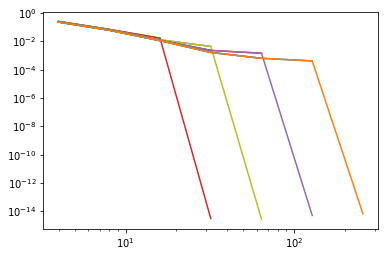

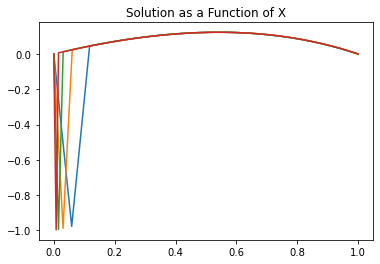

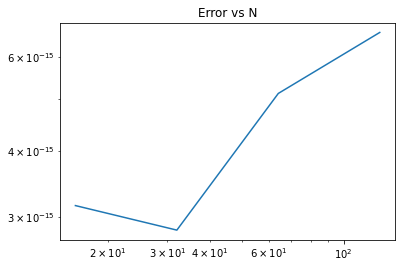

In [54]:
import matplotlib.pyplot as plt 

# Run mygmres and output graphs
def Graphing(gamma):
    n = (16,32,64,128) 
    nerrvec = []
    for i in range(len(n)): 
        x0 = np.zeros(n[i])
        x0[0]= 1
        A, b = driver(n[i],gamma)
        Ierrvec = []
        Ivec = []
        I = 2
        res = 1
        while res > 10**(-6):
            M = np.identity(n[i])
            x,res = mygmres(I, b, x0, n[i], M, A )
            I = I * 2 
            Ierrvec.append(res)
            Ivec.append(I)
            plt.figure(1)
            plt.loglog(Ivec, Ierrvec)

        xscale = np.linspace(0,1,n[i]+2)
        # x[0] = 0
        # y = np.zeros(xscale.shape)
        x = np.insert(x,0,0)
        x = np.append( x, 0)
        # y[1:-1] = x
        # y[-1] = 0
        plt.figure(2)
        plt.plot(xscale,x)
        plt.title("Solution as a Function of X")

        nerrvec.append(res)


    plt.figure(3)
    # plt.subplot(1,2,1)
    plt.loglog(n, nerrvec)
    plt.title("Error vs N")
        
    plt.show()

Graphing(1)
